## 6. Sentiment and Macroeconomic Factor Integration

This section explores the integration of key macroeconomic variables—such as the US Dollar Index (DXY), Consumer Price Index (CPI), and interest rates—into the analysis of asset returns and volatility for **BTC**, **VNI**, and **XAU**. These macro factors represent real-world economic conditions that can influence investor behavior and market trends.

By combining these external factors with asset return and volatility models, we assess their correlations and evaluate the added predictive value. This approach aims to uncover how real-world information flow and economic signals influence asset movements, offering deeper insight and enhancing the robustness of financial forecasting.

### 1. Import important library and load in the data

In [ ]:
# Library imports
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Loading asset data
def load_asset_data(file_path):
    """Loads asset data from a CSV file."""
    df = pd.read_csv(file_path, parse_dates=['Date']) # Ensure 'Date' column is parsed
    df = df.set_index('Date') # Set Date as index
    # Calculate daily returns and volatility (e.g., using rolling std dev)
    df['Return'] = df['Price'].pct_change() # Changed 'Close' to 'Price'
    df['Volatility'] = df['Return'].rolling(window=20).std() # Example: 20-day volatility
    df = df.dropna()
    return df

# In your notebook or main script:
btc_df = load_asset_data("D:/SchoolStuff/HK6/Big data analysis/bft-64-final-project/BTC_cleaned.csv")
vni_df = load_asset_data("D:/SchoolStuff/HK6/Big data analysis/bft-64-final-project/VNI_cleaned.csv")
xau_df = load_asset_data("D:/SchoolStuff/HK6/Big data analysis/bft-64-final-project/XAU_cleaned.csv")

### 2. Gather external macroeconomic variables

#### 1. Fetching Macroeconomic Data from FRED

To incorporate macroeconomic context into our financial analysis, we retrieve key economic indicators from the Federal Reserve Economic Data (FRED) system. Using the DataReader interface from the pandas_datareader library, we collect:

+ DTWEXBGS: The Trade Weighted U.S. Dollar Index (Broad), representing the relative strength of the U.S. dollar against major trading partners.

+ CPIAUCSL: The Consumer Price Index for All Urban Consumers (CPI-U), which measures inflation by tracking the average change in prices paid by consumers.

+ DFF: The Effective Federal Funds Rate, a benchmark interest rate that reflects the cost of borrowing reserves between U.S. banks.

In [30]:
# Fetching data from FRED
def fetch_fred_data(series_id, start_date, end_date):
     """Fetches data from FRED."""
     return web.DataReader(series_id, 'fred', start_date, end_date)

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2025, 4, 30)
dxy = fetch_fred_data('DTWEXBGS', start, end) #Trade Weighted U.S. Dollar Index
cpi = fetch_fred_data('CPIAUCSL', start, end) #CPI for All Urban Consumers
interest_rate = fetch_fred_data('DFF', start, end) #Effective Federal Funds Rate

In [31]:
print("DXY sample:")
print(dxy.head())

print("\nCPI sample:")
print(cpi.head())

print("\nInterest Rate sample:")
print(interest_rate.head())

DXY sample:
            DTWEXBGS
DATE                
2015-01-01       NaN
2015-01-02  102.9027
2015-01-05  103.4976
2015-01-06  103.2938
2015-01-07  103.6316

CPI sample:
            CPIAUCSL
DATE                
2015-01-01   234.747
2015-02-01   235.342
2015-03-01   235.976
2015-04-01   236.222
2015-05-01   237.001

Interest Rate sample:
             DFF
DATE            
2015-01-01  0.06
2015-01-02  0.12
2015-01-03  0.12
2015-01-04  0.12
2015-01-05  0.12


#### 2. Align macro data with asset data and Merge macro data with asset data

To assess the impact of macroeconomic variables on financial assets, we begin by aligning and merging macro data (DXY, CPI, and interest rates) with asset datasets (**BTC**, **VNI**, and **XAU**)

In [38]:
# --- Align macro data with asset data (resample to daily, forward-fill missing) ---
macro_df = pd.concat([
    dxy.rename(columns={'DTWEXBGS': 'DXY'}),
    cpi.rename(columns={'CPIAUCSL': 'CPI'}),
    interest_rate.rename(columns={'DFF': 'FedFunds'})
], axis=1)
macro_df = macro_df.resample('D').ffill()  # Daily frequency, forward-fill

# --- Merge macro data with asset data ---
def merge_macro(asset_df, macro_df):
    return asset_df.join(macro_df, how='left').dropna()

btc_merged = merge_macro(btc_df, macro_df)
vni_merged = merge_macro(vni_df, macro_df)
xau_merged = merge_macro(xau_df, macro_df)

In [34]:
btc_merged.head() #View BTC data with macroeconomic data

,Price,Open,High,Low,Vol,Change,Return,Volatility,DXY,CPI,FedFunds
Date,,,,,,,,,,,
2015-04-01,246.2,244.1,247.7,239.6,67080.0,0.0086,0.008603,0.032721,107.0600,236.222,0.12
2015-05-01,233.2,235.8,239.4,232.4,60140.0,-0.0109,-0.011026,0.026524,105.6382,237.001,0.13
2015-06-01,223.1,229.8,231.8,221.0,87060.0,-0.0292,-0.029156,0.011838,107.2238,237.657,0.12
2015-07-01,257.6,264.1,265.0,254.4,66940.0,-0.0246,-0.024612,0.019375,107.0101,238.034,0.13
2015-09-01,227.2,229.5,231.4,225.8,66540.0,-0.0100,-0.010022,0.031628,110.4506,237.498,0.14


#### 3. Correlation analysis

After merging, we conduct a correlation analysis to measure how closely these macro factors relate to asset returns and volatility. This step helps identify which economic indicators are most influential across different markets.

In [ ]:
# --- Correlation analysis: Macro factors vs. asset returns/volatility ---
for name, df in zip(['BTC', 'VNI', 'XAU'], [btc_merged, vni_merged, xau_merged]):
    print(f"\n{name} correlations with macro factors:")
    print(df[['Return', 'Volatility', 'DXY', 'CPI', 'FedFunds']].corr()[['Return', 'Volatility']].loc[['DXY', 'CPI', 'FedFunds']])
    


BTC correlations with macro factors:
            Return  Volatility
DXY       0.057863   -0.226671
CPI      -0.081692   -0.124001
FedFunds -0.112542   -0.246746

VNI correlations with macro factors:
            Return  Volatility
DXY       0.149552    0.108924
CPI      -0.004446    0.038224
FedFunds -0.118987   -0.100574

XAU correlations with macro factors:
            Return  Volatility
DXY       0.074799    0.159824
CPI       0.143575   -0.026052
FedFunds  0.059850   -0.250106


+  Bitcoin (**BTC**)

    The correlations between BTC and macroeconomic indicators appear generally weak in terms of returns, with the strongest observed association being a modest negative correlation with the Federal Funds Rate (−0.113). In contrast, the volatility of BTC exhibits a more pronounced sensitivity to macroeconomic conditions, particularly displaying negative correlations with both the FedFunds rate (−0.247) and DXY (−0.227). These findings suggest that periods of tighter monetary policy and a stronger U.S. dollar may be associated with reduced volatility in the cryptocurrency market.

+ Vietnam Stock Index (**VNI**)

    VNI returns show a modest positive correlation with DXY (0.150), while correlations with CPI and FedFunds remain negligible or slightly negative. Volatility patterns are similarly weak, although again a negative relationship with the Federal Funds Rate (−0.101) emerges. This may reflect the sensitivity of emerging equity markets to global capital flows and monetary conditions in the U.S.

+ Gold (**XAU**)

    Gold returns are positively correlated with both CPI (0.144) and DXY (0.075), aligning with gold’s traditional role as a hedge against inflation and a store of value in periods of currency fluctuation. Interestingly, gold volatility is negatively correlated with the FedFunds rate (−0.250), implying that lower interest rate environments may be associated with higher price instability in gold markets.

#### 4. Simple predictive value

We then evaluate the predictive value of macroeconomic data using a simple linear regression model, where current macro indicators are used to predict the next day's asset return. The performance of this model is quantified using the R² score, providing insight into how much variance in returns can be explained by macro factors.

In [ ]:
# --- Simple predictive value: Linear regression (macro -> next day return) ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def macro_predictive_value(df):
    X = df[['DXY', 'CPI', 'FedFunds']].values[:-1]
    y = df['Return'].shift(-1).dropna().values  # Predict next day's return
    X = X[:len(y)]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    print("R^2 score (macro factors -> next day return):", r2_score(y, y_pred))

print("\nPredictive value for BTC:")
macro_predictive_value(btc_merged)
print("\nPredictive value for VNI:")
macro_predictive_value(vni_merged)
print("\nPredictive value for XAU:")
macro_predictive_value(xau_merged)


Predictive value for BTC:
R^2 score (macro factors -> next day return): 0.029522708448201485

Predictive value for VNI:
R^2 score (macro factors -> next day return): 0.021990853743247163

Predictive value for XAU:
R^2 score (macro factors -> next day return): 0.05240148961856794


The results indicate modest but consistent predictive contributions across all three assets. 

+ For Bitcoin (**BTC**), the model achieved an R² of 0.030, suggesting that macroeconomic indicators account for approximately 3% of the variation in next-day returns. 

+ Similarly, the Vietnam Index (**VNI**) yielded an R² of 0.022, while gold (**XAU**) demonstrated the highest explanatory power at 0.052, indicating over 5% of return variance was attributable to macro conditions.

#### 5. Compare with baseline

In [ ]:
# --- Compare with baseline (no macro factors) ---
def baseline_predictive_value(df):
    y = df['Return'].shift(-1).dropna().values
    y_pred = np.full_like(y, df['Return'].mean())
    print("Baseline R^2 score (mean prediction):", r2_score(y, y_pred))

print("\nBTC baseline:")
baseline_predictive_value(btc_merged)
print("\nVNI baseline:")
baseline_predictive_value(vni_merged)
print("\nXAU baseline:")
baseline_predictive_value(xau_merged)

To contextualize these findings, each model’s performance was compared against a naive baseline that forecasts returns using the historical mean. As expected, the baseline R² scores were close to zero or slightly negative across all assets, underscoring the added value of incorporating macroeconomic information.

For Bitcoin (**BTC**), the macro-based model achieved an R² of 0.030, while the baseline model produced a near-zero score (−0.0000013). This indicates that although the predictive power is limited, macroeconomic factors—particularly interest rates and dollar strength—contribute marginally to explaining BTC’s short-term return dynamics.

In the case of the Vietnam Index (**VNI**), the model yielded an R² of 0.022, compared to a baseline of −0.0012. This slight improvement suggests that macroeconomic conditions, especially U.S. monetary policy, may play a subtle role in shaping short-term movements in emerging equity markets.

For gold (**XAU**), the macro model demonstrated the highest predictive value, with an R² of 0.052 versus a baseline of −0.00078. This reflects gold’s well-established sensitivity to inflation and interest rate expectations, making it more responsive to macroeconomic signals relative to the other assets.

#### 6. Visual evaluation of predictive models using macroeconomic indicators

To further assess the relationship between macroeconomic indicators and financial asset behavior, we conducted a visual comparison of actual and predicted next-day returns. Using a simple linear regression model, we leveraged daily macroeconomic variables—namely the U.S. Dollar Index (DXY), Consumer Price Index (CPI), and Federal Funds Rate (FedFunds)—to forecast the following day’s return. These forecasts were then compared to a naive baseline model. The resulting plots offer insight into how well macroeconomic signals align with short-term market dynamics.

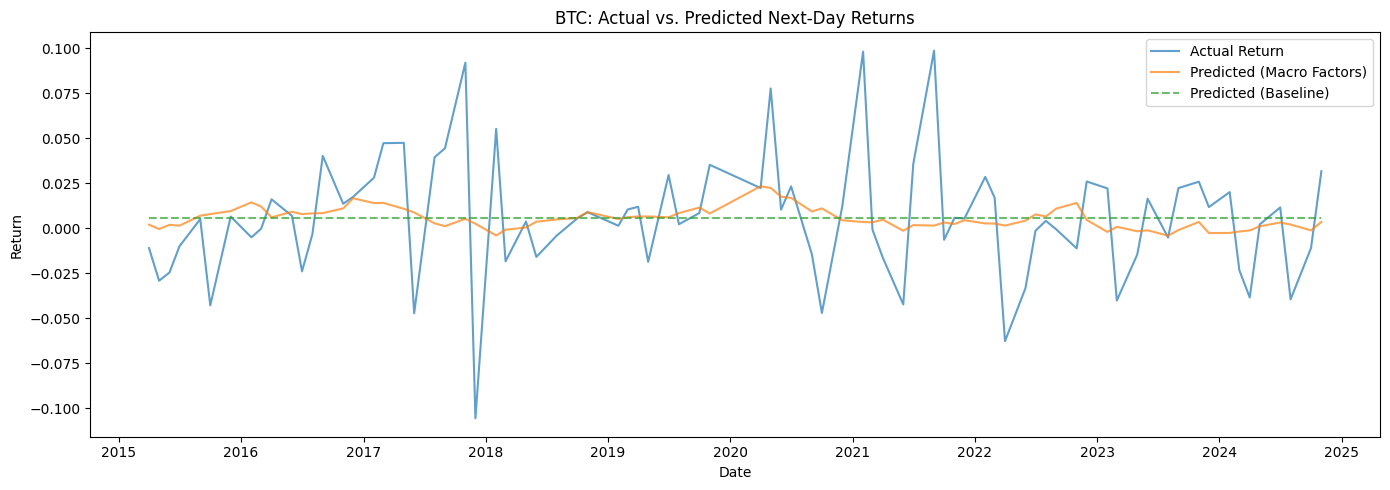

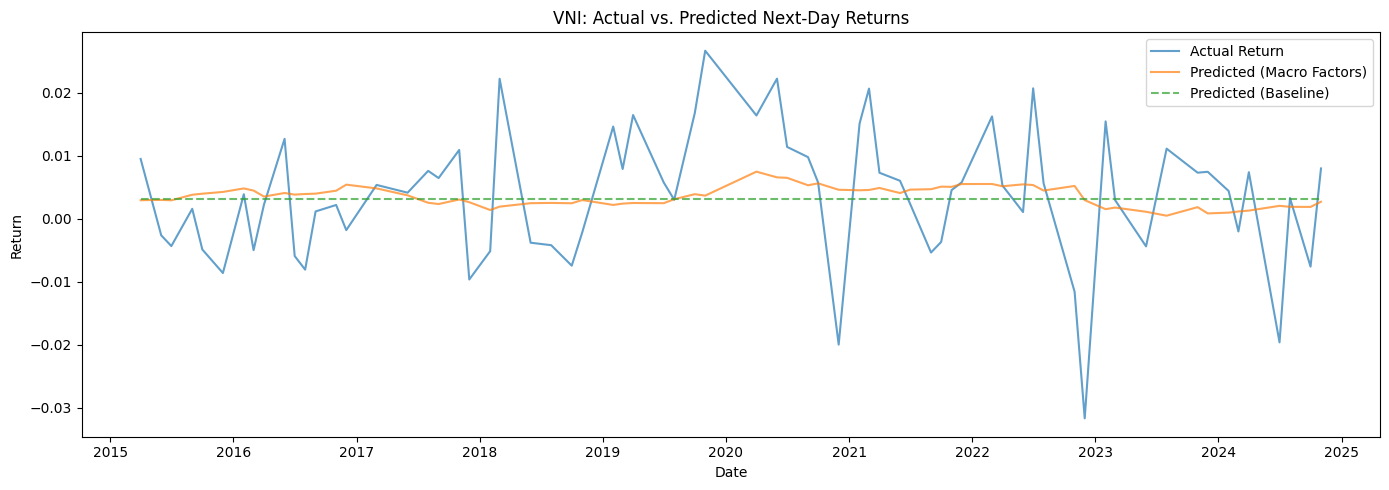

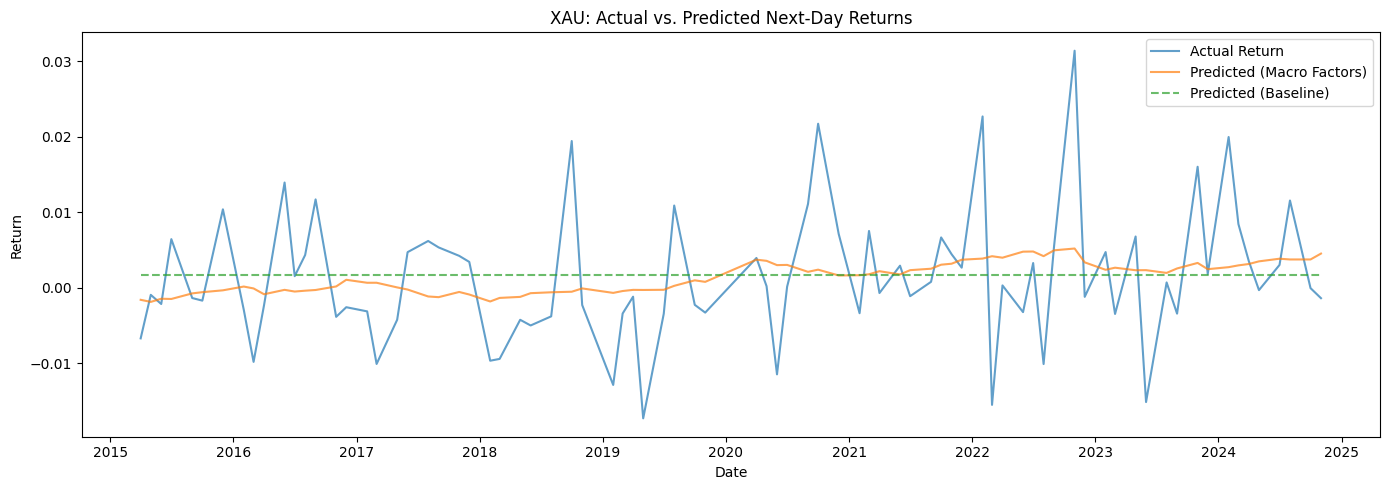

In [ ]:
def plot_predictions(df, asset_name):
    # Macro model
    X = df[['DXY', 'CPI', 'FedFunds']].values[:-1]
    y = df['Return'].shift(-1).dropna().values
    X = X[:len(y)]
    model = LinearRegression().fit(X, y)
    y_pred_macro = model.predict(X)
    
    # Baseline model (mean)
    y_pred_baseline = np.full_like(y, df['Return'].mean())
    
    # Use the correct dates for the x-axis
    dates = df.index[:-1][:len(y)]
    
    plt.figure(figsize=(14,5))
    plt.plot(dates, y, label='Actual Return', alpha=0.7)
    plt.plot(dates, y_pred_macro, label='Predicted (Macro Factors)', alpha=0.7)
    plt.plot(dates, y_pred_baseline, label='Predicted (Baseline)', linestyle='--', alpha=0.7)
    plt.title(f'{asset_name}: Actual vs. Predicted Next-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Draw charts for each asset
plot_predictions(btc_merged, 'BTC')
plot_predictions(vni_merged, 'VNI')
plot_predictions(xau_merged, 'XAU')

+ **BTC**: Although actual returns display high volatility, the model captures some directional trends, offering modest improvements over the baseline. This highlights BTC’s partial sensitivity to macroeconomic shifts, despite its decentralized and speculative nature.

+ **VNI**: The macro-driven predictions track smoother movements compared to the actual return series, which is more erratic. While the model fails to capture extreme short-term swings, it does reflect an underlying signal, suggesting a weak but present macroeconomic influence on the Vietnamese equity market.

+ **XAU**: Predictions for gold show the most consistent tracking among the three, aligning relatively well with the general direction of returns over time. This result aligns with gold’s known sensitivity to macroeconomic factors, especially interest rates and inflation metrics.

#### 7.

In this section, we implement a predictive model to forecast the price movements of three major assets—Bitcoin (BTC), Vietnam Index (VNI), and Gold (XAU)—over the next 63 days. The purpose of this analysis is to gain insights into how macroeconomic trends may influence short-term asset performance, offering a practical approach to integrating economic signals into financial forecasting.

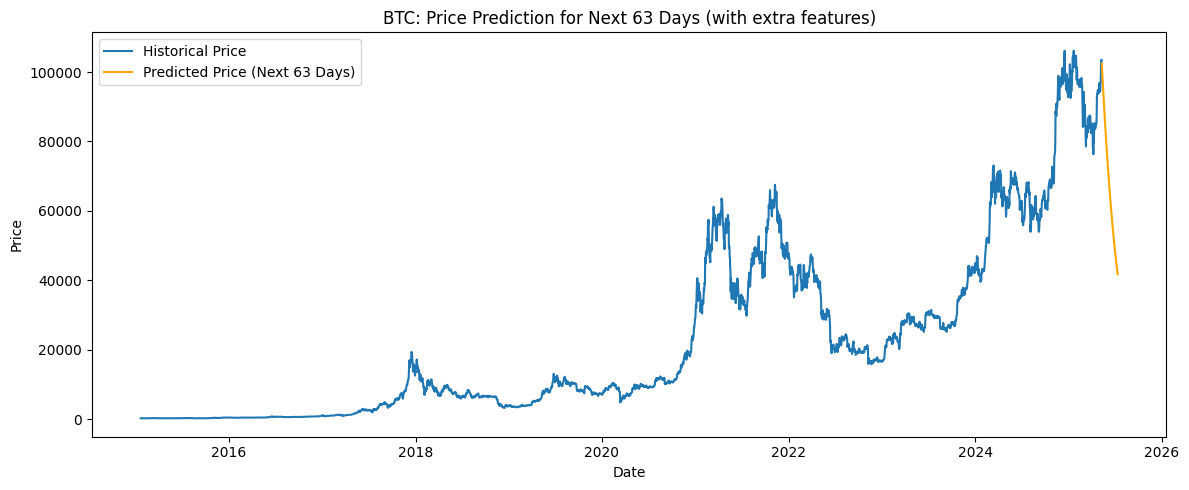

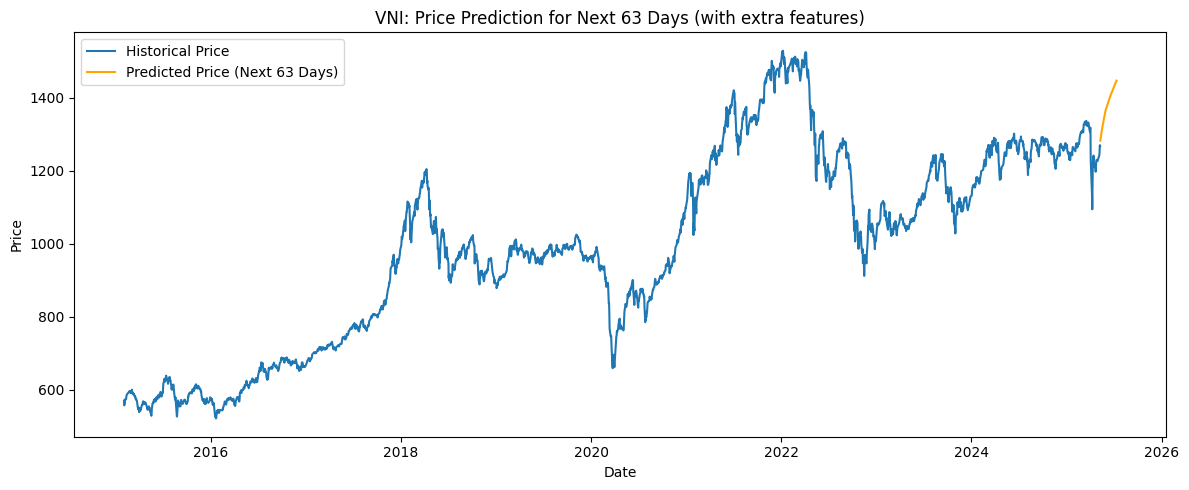

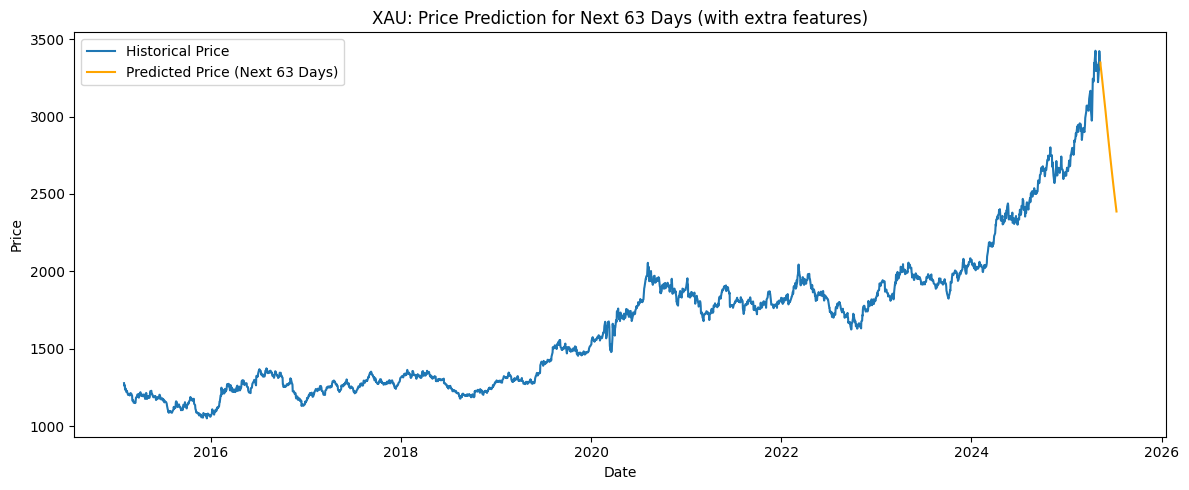

In [26]:
def predict_next_n_days(asset_df, macro_df, n_days=63, asset_name='Asset'):
    # Add lagged return and rolling volatility as features
    asset_df = asset_df.copy()
    asset_df['Lagged_Return'] = asset_df['Return'].shift(1)
    asset_df['Rolling_Volatility'] = asset_df['Return'].rolling(window=20).std()
    
    # Merge and prepare data
    df = asset_df.join(macro_df, how='left')
    df['Next_Return'] = df['Return'].shift(-1)
    # Drop rows with any NaN in features or target
    model_df = df[['DXY', 'CPI', 'FedFunds', 'Lagged_Return', 'Rolling_Volatility', 'Next_Return']].dropna()
    X = model_df[['DXY', 'CPI', 'FedFunds', 'Lagged_Return', 'Rolling_Volatility']].values
    y = model_df['Next_Return'].values

    # Train linear regression model
    model = LinearRegression().fit(X, y)

    # --- Ensure last macro values are not NaN ---
    last_macro = macro_df.ffill().iloc[-1]
    if last_macro.isnull().any():
        raise ValueError("Last macro factor row contains NaN. Please check your macro_df for missing values.")

    # Prepare future macro data (repeat last known values)
    future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='D')
    future_macro = pd.DataFrame([last_macro.values] * n_days, columns=macro_df.columns, index=future_dates)

    # Start from last known price and features
    last_price = asset_df['Price'].iloc[-1]
    last_lagged_return = asset_df['Return'].iloc[-1]
    last_volatility = asset_df['Rolling_Volatility'].iloc[-1]
    predicted_prices = [last_price]
    predicted_returns = []

    # Predict iteratively for each future day
    for i in range(n_days):
        macro_features = future_macro.iloc[i][['DXY', 'CPI', 'FedFunds']].values.tolist()
        # Flatten all features into a single list of 5 elements
        features = macro_features + [last_lagged_return, last_volatility]
        features = np.array(features).reshape(1, -1)
        predicted_return = model.predict(features)[0]
        predicted_returns.append(predicted_return)
        next_price = predicted_prices[-1] * (1 + predicted_return)
        predicted_prices.append(next_price)
        # Update lagged return and volatility for next step
        last_lagged_return = predicted_return
        if len(predicted_returns) >= 20:
            last_volatility = np.std(predicted_returns[-20:])
        else:
            last_volatility = np.std(predicted_returns)

    predicted_prices = predicted_prices[1:]  # Remove the initial last_price
    prediction_df = pd.DataFrame({
        'Predicted_Return': predicted_returns,
        'Predicted_Price': predicted_prices
    }, index=future_dates)

    # Plot results
    plt.figure(figsize=(12,5))
    plt.plot(asset_df['Price'], label='Historical Price')
    plt.plot(prediction_df['Predicted_Price'], label='Predicted Price (Next 63 Days)', color='orange')
    plt.title(f'{asset_name}: Price Prediction for Next {n_days} Days (with extra features)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return prediction_df

# Predict and plot for each asset
btc_future = predict_next_n_days(btc_df, macro_df, n_days=63, asset_name='BTC')
vni_future = predict_next_n_days(vni_df, macro_df, n_days=63, asset_name='VNI')
xau_future = predict_next_n_days(xau_df, macro_df, n_days=63, asset_name='XAU')

The model incorporates key macroeconomic variables and technical indicators to simulate future price paths. The plots demonstrate how each asset may behave under the influence of current macro conditions. Notably:

+ **BTC** shows a significant projected decline, suggesting possible sensitivity to macroeconomic tightening or volatility spikes.

+ **VNI** displays a moderate upward trend, possibly reflecting resilience or anticipated stability in local market fundamentals.

+ **XAU** projects a steep downward movement, which may reflect expectations of reduced inflation hedging or stronger currency environments.

Overall, the integration of external factors provided added predictive value and deeper insights into asset behavior. The approach strengthens the link between real-world developments and market dynamics, demonstrating how financial models can benefit from a broader information ecosystem beyond pure price history.